# Exploratory Analysis

Group project for the 2019 Data Science Workshop at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [1]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy.stats import linregress
import datetime as dt

pd.options.display.max_columns = 999

## Load data

Note that the data files are too large to upload to GitHub - instead, the directory `./data/` has been added to the .gitignore, which should contain the following files on your local machine, all downloaded from the Kaggle competition website:

* sample_submission_v2.csv
* test_v2.csv
* train_v2.csv

Time windows we are interested in:

In [2]:
train_start_date = dt.datetime(2016, 8, 1)
train_end_date = dt.datetime(2018, 4, 30)
train_duration = train_end_date - train_start_date + dt.timedelta(days=1)
print('train duration = {} days'.format(train_duration.days))

train duration = 638 days


In [3]:
test_start_date = dt.datetime(2018, 5, 1)
test_end_date = dt.datetime(2018, 10, 15)
test_duration = test_end_date - test_start_date + dt.timedelta(days=1)
print('test duration = {} days'.format(test_duration.days))

test duration = 168 days


In [4]:
predict_start_date = dt.datetime(2018, 12, 1)
predict_end_date = dt.datetime(2019, 1, 31)
predict_duration = predict_end_date - predict_start_date + dt.timedelta(days=1)
print('predict duration = {} days'.format(predict_duration.days))

predict duration = 62 days


In [5]:
gap_duration = predict_start_date - test_end_date - dt.timedelta(days=1)
print('gap duration = {} days'.format(gap_duration.days))

gap duration = 46 days


What fraction of the dataset is one test duration?

In [6]:
test_duration.days / train_duration.days

0.26332288401253917

What is the last day we can start a training time window on?

In [7]:
train_end_date - (test_duration + predict_duration + gap_duration)

datetime.datetime(2017, 7, 28, 0, 0)

A middle time slice, to get 3 slices in total:

In [8]:
train_start_date + (((train_end_date - (test_duration + predict_duration + gap_duration)) - train_start_date) / 2)

datetime.datetime(2017, 1, 28, 12, 0)

Now read in the data:

In [9]:
# to read in a previously created and cleaned slice, set this to False
create_slice = False

In [10]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId':'str'}) # Important!!
    
    # fix the formatting in these two columns, and convert them into lists of dictionaries
    df['hits'] = df['hits'].str.replace("{'", '{"')
    df['hits'] = df['hits'].str.replace("'}", '"}')
    df['hits'] = df['hits'].str.replace(": '", ': "')
    df['hits'] = df['hits'].str.replace("',", '",')
    df['hits'] = df['hits'].str.replace(", '", ', "')
    df['hits'] = df['hits'].str.replace("':", '":')
    df['hits'] = df['hits'].str.replace("\'", "'")
    df['hits'] = df['hits'].str.replace('"7" ', '"7in ')
    df['hits'] = df['hits'].str.replace('/7" ', '/7in ')
    df['hits'] = df['hits'].str.replace('"Player"', "'Player'")
    df['hits'] = df['hits'].str.replace('True', 'true')
    df['hits'] = df['hits'].str.replace('False', 'false')
    df['hits'] = df['hits'].apply(json.loads)
    
    df['customDimensions'] = df['customDimensions'].str.replace("{'", '{"')
    df['customDimensions'] = df['customDimensions'].str.replace("'}", '"}')
    df['customDimensions'] = df['customDimensions'].str.replace(": '", ': "')
    df['customDimensions'] = df['customDimensions'].str.replace("',", '",')
    df['customDimensions'] = df['customDimensions'].str.replace(", '", ', "')
    df['customDimensions'] = df['customDimensions'].str.replace("':", '":')
    df['customDimensions'] = df['customDimensions'].str.replace("\'", "'")
    df['customDimensions'] = df['customDimensions'].str.replace('True', 'true')
    df['customDimensions'] = df['customDimensions'].str.replace('False', 'false')
    df['customDimensions'] = df['customDimensions'].apply(json.loads)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [11]:
if create_slice == True:
    
    # set slice dates here
    slice_start_date = dt.datetime(2017,7,28)
    slice_end_date = slice_start_date + test_duration - dt.timedelta(days=1)
    predict_slice_start_date = slice_end_date + gap_duration - dt.timedelta(days=1)
    predict_slice_end_date = predict_slice_start_date + predict_duration - dt.timedelta(days=1)
    
    # read in .csv, and covert the date column to datetime
    train = pd.read_csv('./data/train_v2.csv',dtype={'fullVisitorId':'str'})
    print('1/4 : Raw training read in.')
    train_date = pd.to_datetime(train['date'], format='%Y%m%d')
    
    # slice out train dataframe
    train_slice = train[(train_date>=slice_start_date) & (train_date<=slice_end_date)]
    train_predict_slice = train[(train_date>=predict_slice_start_date) & (train_date<=predict_slice_end_date)]
    
    # reset indexes
    train_slice.reset_index(inplace=True,drop=True)
    train_predict_slice.reset_index(inplace=True,drop=True)
    
    # save to .csv
    train_slice.to_csv('./data/train_slice_01.csv', index=False)
    train_predict_slice.to_csv('./data/train_predict_slice_01.csv', index=False)
    
    # load .csv's back in, but using the loading function to flatten most of the JSON columns
    train_slice = load_df('./data/train_slice_01.csv')
    train_predict_slice = load_df('./data/train_predict_slice_01.csv')
    print('2/4 : Sliced training read in.')
    
    # only keep the target column for the prediction slice
    train_predict_slice = train_predict_slice[['fullVisitorId','totals.transactionRevenue']]
    
    # remove columns that have no information from the training slice
    NA_cols = []
    for col in train_slice.columns:
        if col!='hits' and col!='customDimensions':
            if train_slice[col].nunique(dropna=False)==1:
                NA_cols.append(col)
    train_slice.drop(NA_cols, axis=1, inplace=True)
    print('3/4 : Bad columns dropped.')
    
    # save to .csv
    train_slice.to_csv('./data/train_slice_cleaned_01.csv', index=False)
    train_predict_slice.to_csv('.data/train_predict_slice_cleaned_01.csv', index=False)
    print('4/4 : Cleaned data saved.')
    
else:
    train_slice = pd.read_csv('./data/train_slice_cleaned_01.csv', dtype={'fullVisitorId':'str'})
    train_predict_slice = pd.read_csv('./data/train_predict_slice_cleaned_01.csv', dtype={'fullVisitorId':'str'})

In [12]:
train_slice.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1.0,1,1.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2.0,2,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1.0,2.0,1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1.0,2.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1.0,2.0,1,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [13]:
train_predict_slice.head()

,fullVisitorId,totals.transactionRevenue
0,297385299245448775,NaN
1,3777760237579806632,NaN
2,7737791798744373241,NaN
3,8758612413879310842,NaN
4,850747690602245428,NaN


Use the following to identify json load errors...:

## Simple exploration

In [14]:
train_slice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501405 entries, 0 to 501404
Data columns (total 40 columns):
channelGrouping                                 501405 non-null object
customDimensions                                501405 non-null object
date                                            501405 non-null int64
fullVisitorId                                   501405 non-null object
hits                                            501405 non-null object
visitId                                         501405 non-null int64
visitNumber                                     501405 non-null int64
visitStartTime                                  501405 non-null int64
device.browser                                  501405 non-null object
device.deviceCategory                           501405 non-null object
device.isMobile                                 501405 non-null bool
device.operatingSystem                          501405 non-null object
geoNetwork.city                            

### Target

In [15]:
train_predict_slice['fullVisitorId'].value_counts().head()

0603203541488487946    123
6829200181358925007     76
0348420048060754000     65
3884810646891698298     58
3195529996221539592     49
Name: fullVisitorId, dtype: int64

In [16]:
target = train_predict_slice.groupby('fullVisitorId')['totals.transactionRevenue'].sum()
target.sort_index(inplace=True)
target = pd.DataFrame({'fullVisitorId':target.index,
                       'total_predict_revenue':target.values})

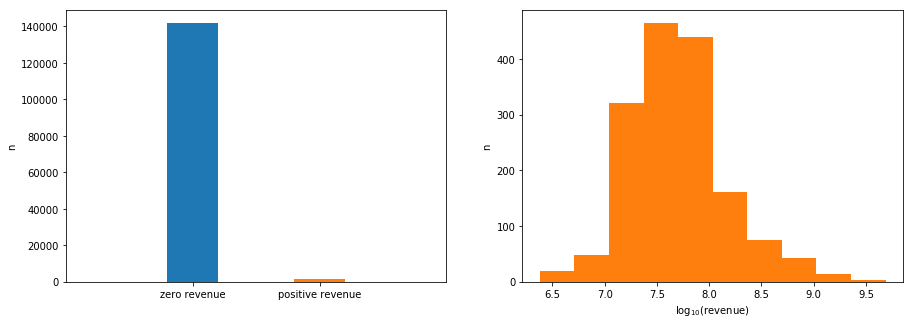

In [17]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

ax[0].bar([0,1],
          [len(target[target['total_predict_revenue']==0]),len(target[target['total_predict_revenue']!=0])],
          width=0.4, color=['C0','C1'])
ax[0].set_xlim(-1,2)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['zero revenue', 'positive revenue'])
ax[0].set_ylabel('n')

ax[1].hist(np.log10(target[target['total_predict_revenue']!=0]['total_predict_revenue']), color='C1')
ax[1].set_xlabel('log$_{10}$(revenue)')
ax[1].set_ylabel('n')

plt.show(fig)

Add a column that denotes:

* if the visitor did not return in the prediction slice: "DNR"
* if the visitor returned in the prediction slice but did not generate any revenue: "RZR"
* if the visitor returned in the prediction slice and generated revenue: "RPR"

In [18]:
# sort by visitor ID
train_slice.sort_values('fullVisitorId', inplace=True)
train_slice.reset_index(drop=True, inplace=True)

# merge the prediction and training slices on the full-visitor ID
train_slice = train_slice.merge(target, how='left', on='fullVisitorId')

In [19]:
train_slice.loc[train_slice['total_predict_revenue'].isnull(), 'prediction_flag'] = 'DNR'
train_slice.loc[train_slice['total_predict_revenue']==0, 'prediction_flag'] = 'RZR'
train_slice.loc[train_slice['total_predict_revenue']>0, 'prediction_flag'] = 'RPR'

In [20]:
train_slice['visitStartTime_hour'] = pd.to_datetime(train_slice['visitStartTime'], unit='s').dt.hour
train_slice['visitStartTime_day'] = pd.to_datetime(train_slice['visitStartTime'], unit='s').dt.weekday

In [21]:
train_slice_DNR = train_slice[train_slice['prediction_flag']=='DNR']
train_slice_RZR = train_slice[train_slice['prediction_flag']=='RZR']
train_slice_RPR = train_slice[train_slice['prediction_flag']=='RPR']

### Categorical features

Look at categorical variables:

In [22]:
def value_count_plot(feature):
    """
    Make a value count plot for categorical features.
    
    Parameters
    ----------
    feature : str
        Name of feature.
    """
    value_counts = train_slice[feature].value_counts(dropna=False)
    
    fig, ax = plt.subplots(figsize=(15,7))
    
    ax.plot(np.arange(len(value_counts)), value_counts, 'o-')
    
    ax.set_xlabel('category index')
    ax.set_ylabel('n')
    
    return fig, ax

In [23]:
def three_bars(feature):
    """
    Make bar plots that compare DNR, RZR, RPR for categorical features.
    
    Parameters
    ----------
    feature : str
        Name of feature.
    """
    unique_vals = train_slice[feature].unique()
    n_vals = len(unique_vals)

    val_counts_DNR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature].isnull()])
        else:
            val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature]==unique_vals[i]])

    val_counts_RZR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature].isnull()])
        else:
            val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature]==unique_vals[i]])

    val_counts_RPR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature].isnull()])
        else:
            val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature]==unique_vals[i]])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    ax[0].bar(np.arange(n_vals),val_counts_DNR,color='C2')
    ax[0].set_xticks(np.arange(n_vals))
    ax[0].set_xticklabels(unique_vals, rotation=90)
    ax[0].set_title('DNR')

    ax[1].bar(np.arange(n_vals),val_counts_RZR,color='C0')
    ax[1].set_xticks(np.arange(n_vals))
    ax[1].set_xticklabels(unique_vals, rotation=90)
    ax[1].set_title('RZR')

    ax[2].bar(np.arange(n_vals),val_counts_RPR,color='C1')
    ax[2].set_xticks(np.arange(n_vals))
    ax[2].set_xticklabels(unique_vals, rotation=90)
    ax[2].set_title('RPR')

    plt.show(fig)

In [24]:
def three_bars_OTHER(feature, unique_vals):
    """
    Make bar plots that compare DNR, RZR, RPR for categorical features, including OTHER.
    
    Parameters
    ----------
    feature : str
        Name of feature.
        
    unique_vals : list
        List of categories - must include 'OTHER' as the last item.
    """
    n_vals = len(unique_vals)

    val_counts_DNR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature]==unique_vals[i]])
            else:
                val_counts_DNR[i] = len(train_slice_DNR) - np.sum(val_counts_DNR)

    val_counts_RZR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature]==unique_vals[i]])
            else:
                val_counts_RZR[i] = len(train_slice_RZR) - np.sum(val_counts_RZR)

    val_counts_RPR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature]==unique_vals[i]])
            else:
                val_counts_RPR[i] = len(train_slice_RPR) - np.sum(val_counts_RPR)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    ax[0].bar(np.arange(n_vals),val_counts_DNR,color='C2')
    ax[0].set_xticks(np.arange(n_vals))
    ax[0].set_xticklabels(unique_vals, rotation=90)
    ax[0].set_title('DNR')

    ax[1].bar(np.arange(n_vals),val_counts_RZR,color='C0')
    ax[1].set_xticks(np.arange(n_vals))
    ax[1].set_xticklabels(unique_vals, rotation=90)
    ax[1].set_title('RZR')

    ax[2].bar(np.arange(n_vals),val_counts_RPR,color='C1')
    ax[2].set_xticks(np.arange(n_vals))
    ax[2].set_xticklabels(unique_vals, rotation=90)
    ax[2].set_title('RPR')

    plt.show(fig)

#### channelGrouping

In [25]:
train_slice['channelGrouping'].value_counts(dropna=False)

Organic Search    227272
Direct             83191
Referral           64074
Social             62581
Display            42811
Paid Search        12672
Affiliates          8796
(Other)                8
Name: channelGrouping, dtype: int64

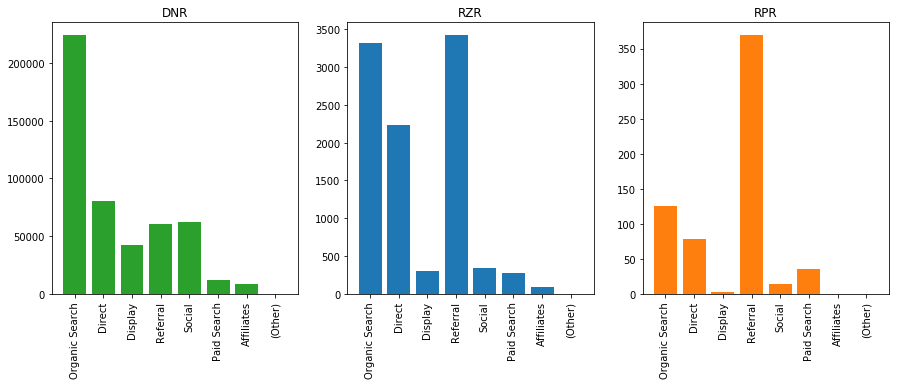

In [26]:
three_bars('channelGrouping')

#### device.browser

In [27]:
train_slice['device.browser'].value_counts(dropna=False)

Chrome                        340412
Safari                         87614
Firefox                        16825
Samsung Internet               12168
Internet Explorer              10875
Android Webview                10725
Edge                            5952
Safari (in-app)                 5371
Opera Mini                      5137
Opera                           2325
UC Browser                      1888
Amazon Silk                      598
YaBrowser                        501
Android Browser                  272
Coc Coc                          265
Mozilla Compatible Agent         142
Puffin                           102
BlackBerry                        47
Maxthon                           32
MRCHROME                          30
Nokia Browser                     20
osee2unifiedRelease               19
Nintendo Browser                  15
Apple-iPhone7C2                    7
SeaMonkey                          6
Seznam                             5
+Simple Browser                    5
M

In [28]:
train_slice_RZR['device.browser'].value_counts(dropna=False)

Chrome               7687
Safari               1218
Firefox               358
Internet Explorer     318
Samsung Internet      184
Edge                  118
Opera Mini             40
Android Webview        25
Safari (in-app)        10
Opera                   5
Amazon Silk             3
Coc Coc                 1
Name: device.browser, dtype: int64

In [29]:
train_slice_RPR['device.browser'].value_counts(dropna=False)

Chrome               574
Firefox               30
Safari                22
Internet Explorer      1
Name: device.browser, dtype: int64

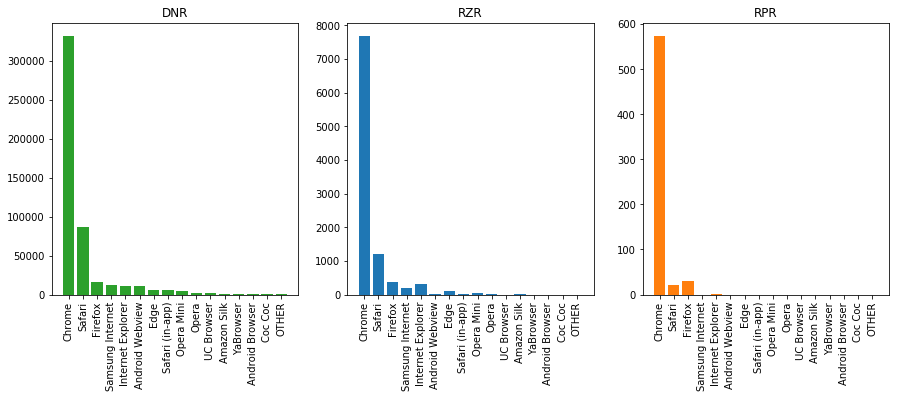

In [30]:
feature = 'device.browser'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>200].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### device.deviceCategory

In [31]:
train_slice['device.deviceCategory'].value_counts(dropna=False)

desktop    302981
mobile     173769
tablet      24655
Name: device.deviceCategory, dtype: int64

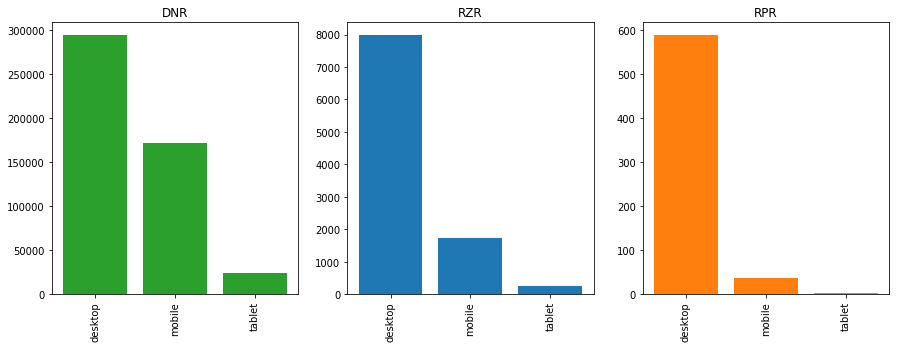

In [32]:
three_bars('device.deviceCategory')

#### device.isMobile

In [33]:
train_slice['device.isMobile'].value_counts(dropna=False)

False    303010
True     198395
Name: device.isMobile, dtype: int64

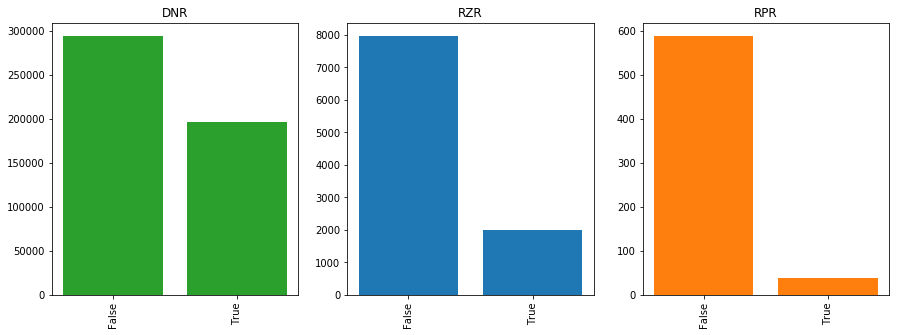

In [34]:
three_bars('device.isMobile')

#### device.operatingSystem

In [35]:
train_slice['device.operatingSystem'].value_counts(dropna=False)

Windows             162888
Android             115165
Macintosh           109836
iOS                  77159
Linux                17600
Chrome OS            13576
(not set)             3908
Tizen                  318
Samsung                316
Windows Phone          312
OS/2                   157
BlackBerry             102
Xbox                    38
Nintendo WiiU           12
FreeBSD                  6
Firefox OS               4
Playstation Vita         3
Nintendo 3DS             3
SunOS                    1
OpenBSD                  1
Name: device.operatingSystem, dtype: int64

In [36]:
train_slice_RZR['device.operatingSystem'].value_counts(dropna=False)

Macintosh    4257
Windows      2666
Android      1030
iOS           927
Linux         681
Chrome OS     379
(not set)      26
Samsung         1
Name: device.operatingSystem, dtype: int64

In [37]:
train_slice_RPR['device.operatingSystem'].value_counts(dropna=False)

Macintosh    497
Windows       54
Linux         35
Android       19
iOS           19
Chrome OS      3
Name: device.operatingSystem, dtype: int64

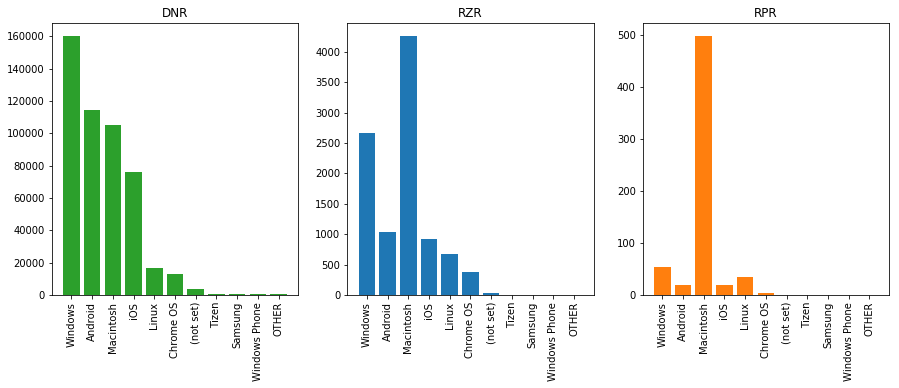

In [38]:
feature = 'device.operatingSystem'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>300].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### geoNetwork.continent

In [39]:
train_slice['geoNetwork.continent'].value_counts(dropna=False)

Americas     275631
Europe       104450
Asia         103758
Africa         8563
Oceania        8339
(not set)       664
Name: geoNetwork.continent, dtype: int64

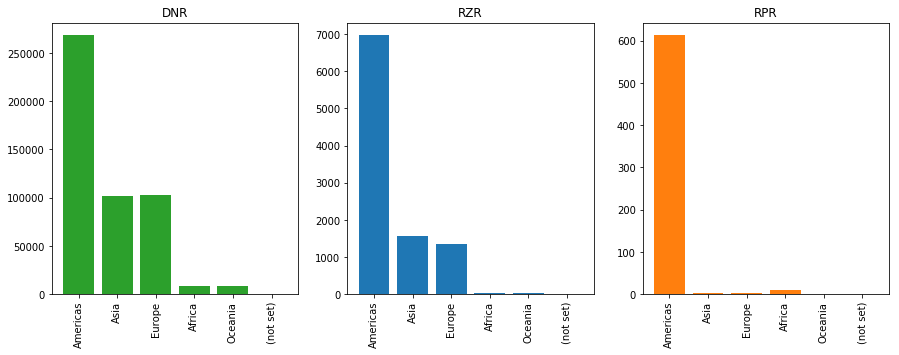

In [40]:
three_bars('geoNetwork.continent')

#### geoNetwork.subContinent

In [41]:
train_slice['geoNetwork.subContinent'].value_counts(dropna=False)

Northern America      244122
Southern Asia          35724
Northern Europe        35132
Western Europe         34146
Southeast Asia         27367
Eastern Asia           26335
South America          20760
Southern Europe        17691
Eastern Europe         17481
Western Asia           13862
Central America         9370
Australasia             8230
Northern Africa         3498
Western Africa          2244
Eastern Africa          1434
Caribbean               1379
Southern Africa         1095
(not set)                664
Central Asia             470
Middle Africa            292
Micronesian Region        52
Melanesia                 38
Polynesia                 19
Name: geoNetwork.subContinent, dtype: int64

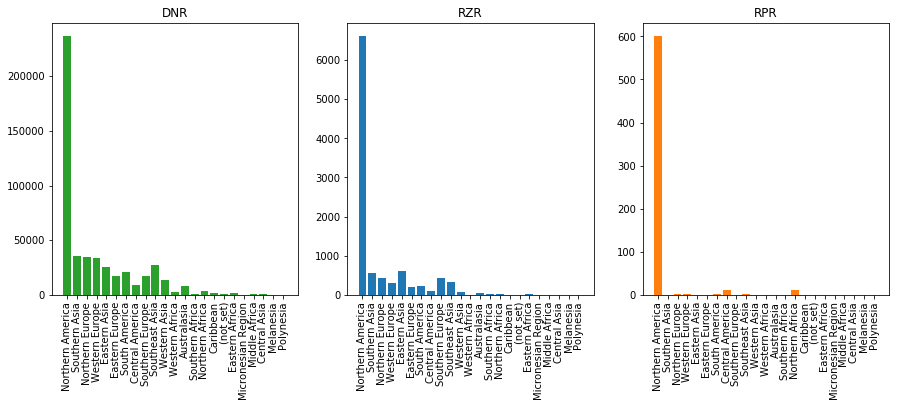

In [42]:
three_bars('geoNetwork.subContinent')

#### geoNetwork.city

In [43]:
train_slice['geoNetwork.city'].value_counts(dropna=False)

not available in demo dataset    270979
Mountain View                     19546
(not set)                         19318
New York                          14385
San Francisco                     10438
Sunnyvale                          8548
London                             7148
San Jose                           6107
Los Angeles                        5515
Chicago                            5210
Bengaluru                          3515
Dublin                             2876
Seattle                            2813
Toronto                            2812
Bangkok                            2790
Mumbai                             2733
Hyderabad                          2593
Sydney                             2576
Paris                              2443
Dallas                             2391
Houston                            2322
Chennai                            2265
Washington                         2208
Austin                             2128
Sao Paulo                          2107


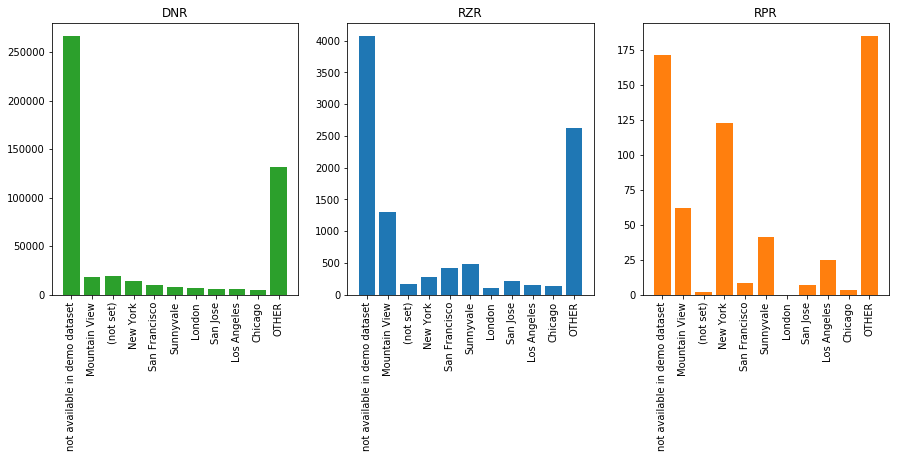

In [44]:
feature = 'geoNetwork.city'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>5000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### geoNetwork.networkDomain

In [45]:
train_slice['geoNetwork.networkDomain'].value_counts(dropna=False)

(not set)                    161939
unknown.unknown               72903
comcast.net                   16585
rr.com                         9282
verizon.net                    8593
hinet.net                      5233
comcastbusiness.net            4303
virginm.net                    4206
optonline.net                  3313
cox.net                        3214
sbcglobal.net                  3134
att.net                        3093
google.com                     3089
btcentralplus.com              2828
prod-infinitum.com.mx          2575
qwest.net                      2329
ttnet.com.tr                   2108
spcsdns.net                    2076
rima-tde.net                   2067
bell.ca                        1969
bhn.net                        1956
vnpt.vn                        1929
telecomitalia.it               1727
shawcable.net                  1676
airtelbroadband.in             1629
asianet.co.th                  1605
t-ipconnect.de                 1566
actcorp.in                  

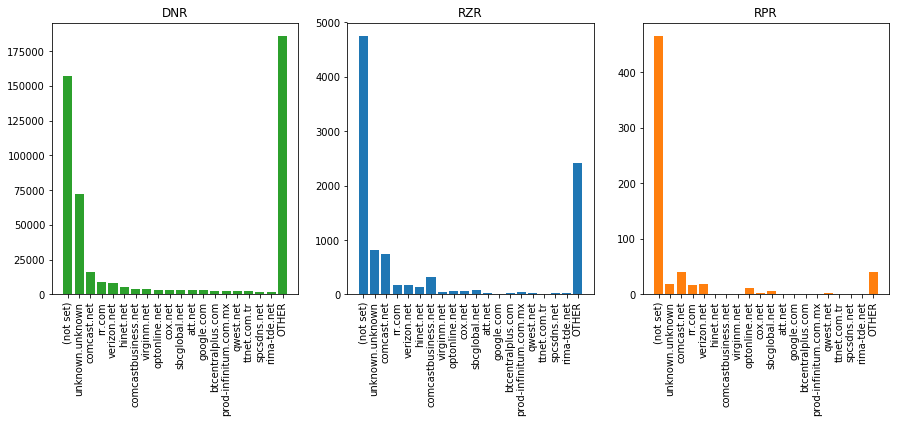

In [46]:
feature = 'geoNetwork.networkDomain'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>2000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.adContent

In [47]:
train_slice['trafficSource.adContent'].value_counts(dropna=False)

NaN                                   456660
Google Merchandise Store               38487
Smart display ad - 8/17/2017            1918
Google Merchandise Collection            955
Display Ad created 3/11/14               766
Google Online Store                      447
Official Google Merchandise              352
Placement Accessories 300 x 250          278
Placement Accessores 300 x 250           212
Ad from 12/15/17                         208
Placement Elecronics 300 x 250           190
{KeyWord:Google Brand Items}             160
Placement Drinkware 300x250               98
Bags 300x250                              90
Placement Office 300x250                  79
{KeyWord:Google Merchandise}              79
Bags 336x280                              49
Placement 336x280                         47
Swag with Google Logos                    45
Placement Accessories 160 x 600           27
Placement Electronics 160 x 600           25
Placement Accessories 336 x 280           23
Drinkware 

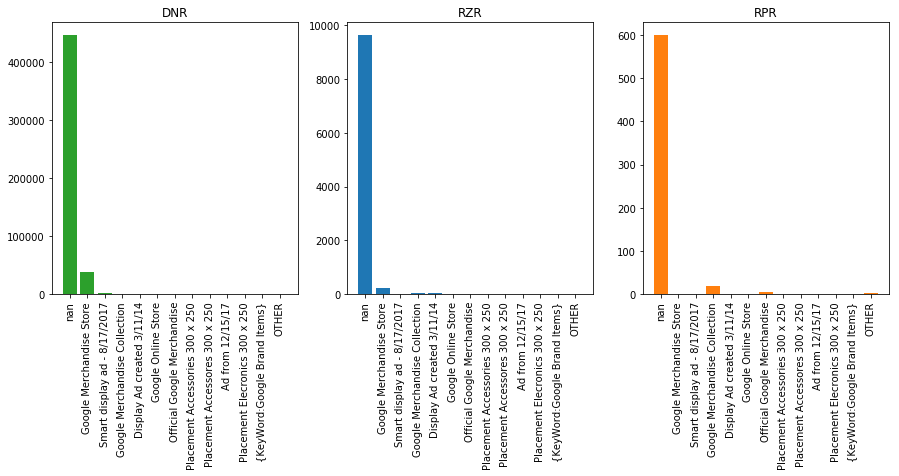

In [48]:
feature = 'trafficSource.adContent'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>100].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.adwordsClickInfo.adNetworkType

In [49]:
train_slice['trafficSource.adwordsClickInfo.adNetworkType'].value_counts(dropna=False)

NaN                450959
Content             40398
Google Search       10047
Search partners         1
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: int64

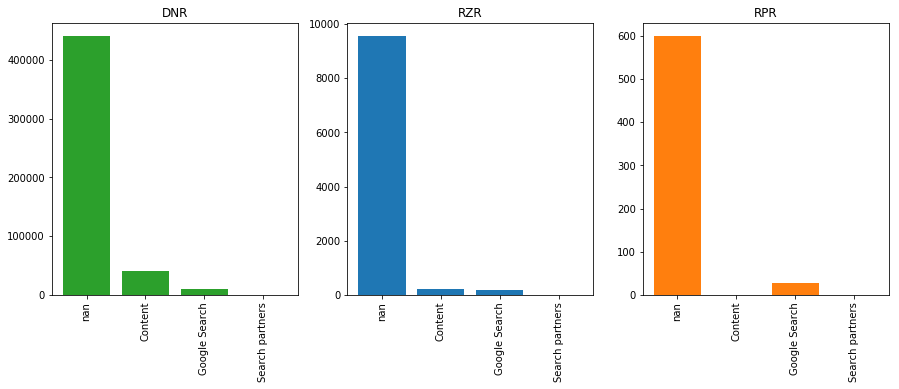

In [50]:
three_bars('trafficSource.adwordsClickInfo.adNetworkType')

#### trafficSource.adwordsClickInfo.page

In [51]:
train_slice['trafficSource.adwordsClickInfo.page'].value_counts(dropna=False)

NaN    450959
1.0     49207
2.0       965
3.0       159
4.0        77
5.0        23
6.0        10
7.0         3
8.0         1
9.0         1
Name: trafficSource.adwordsClickInfo.page, dtype: int64

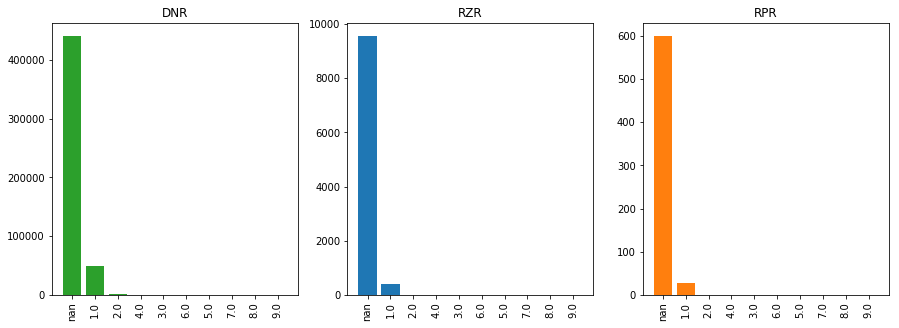

In [52]:
three_bars('trafficSource.adwordsClickInfo.page')

#### trafficSource.adwordsClickInfo.slot

In [53]:
train_slice['trafficSource.adwordsClickInfo.slot'].value_counts(dropna=False)

NaN    450959
RHS     40489
Top      9957
Name: trafficSource.adwordsClickInfo.slot, dtype: int64

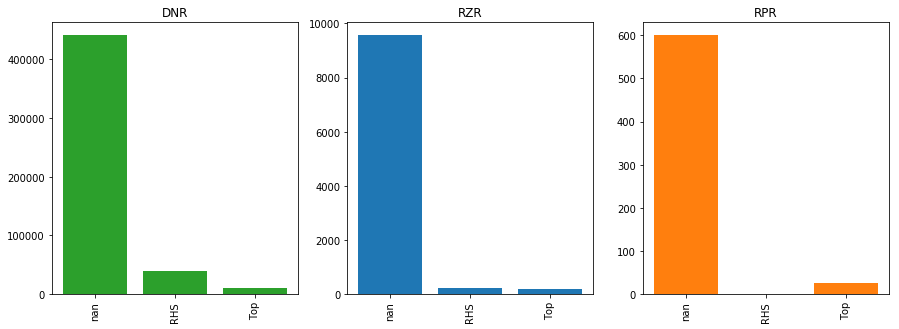

In [54]:
three_bars('trafficSource.adwordsClickInfo.slot')

#### trafficSource.adwordsClickInfo.gclId

In [55]:
train_slice['trafficSource.adwordsClickInfo.gclId'].value_counts(dropna=False)

NaN                                                                                             450940
CN_Whvvc_9UCFd6LswodGTgKCQ                                                                          74
COT1-vPT4tYCFZWNswodcwsHxg                                                                          60
CI2Ap4L32tYCFY-1wAodeHEHPA                                                                          41
CPSo2PeD3tYCFYk_GwodJrEEUg                                                                          38
CKKrvpbe2dYCFdYSaAodSHAOGw                                                                          37
CN3fusbjvtYCFQsmhgodIEQO-g                                                                          36
CMa4z8jL29YCFdmIswodNRAHRg                                                                          35
CP273vOzr9YCFQEHaQoduBgHSA                                                                          35
CKvL9K7o-tUCFQ52fgodJ6kAzg                                               

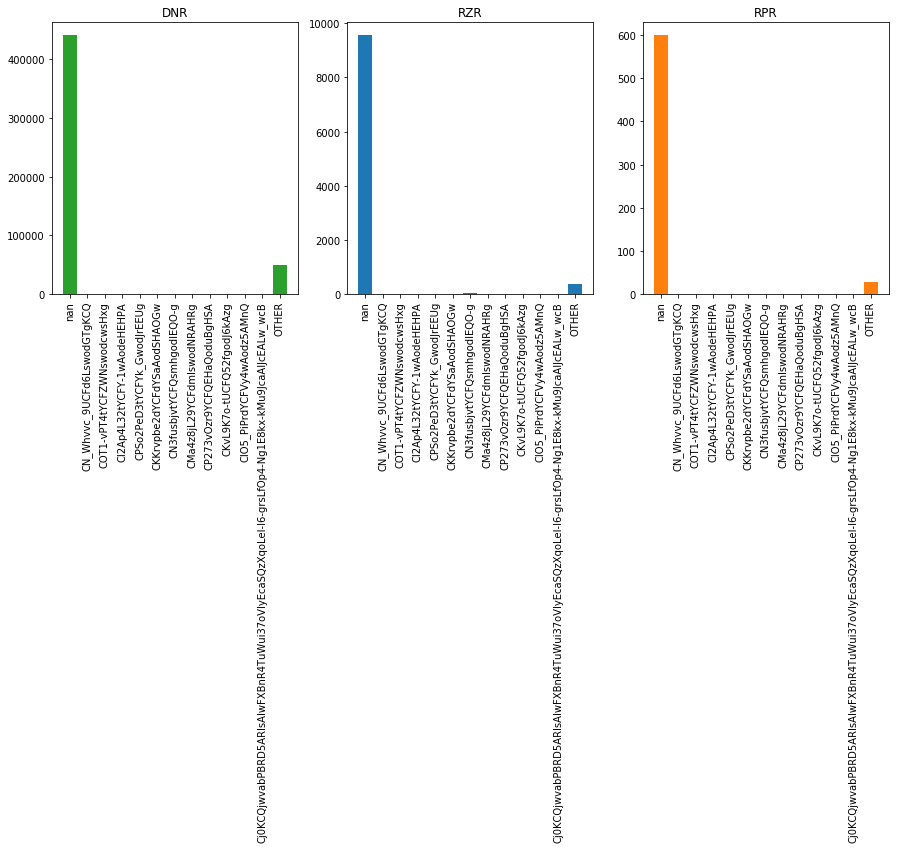

In [56]:
feature = 'trafficSource.adwordsClickInfo.gclId'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>30].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.medium

In [57]:
train_slice['trafficSource.medium'].value_counts(dropna=False)

organic      225936
(none)       124465
referral      86811
cpc           53000
affiliate      8796
cpm            2389
(not set)         8
Name: trafficSource.medium, dtype: int64

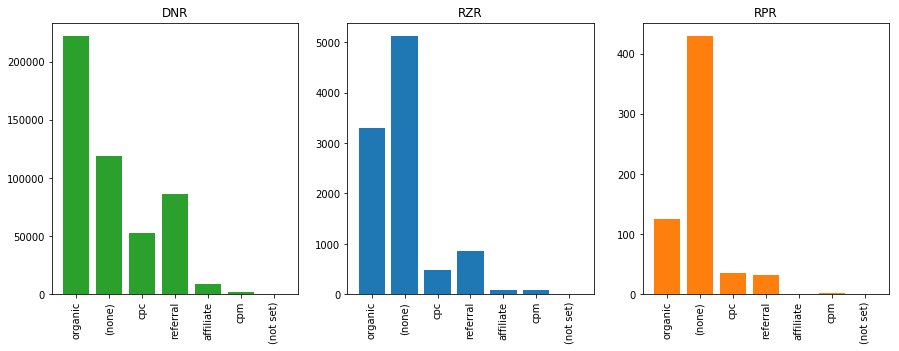

In [58]:
three_bars('trafficSource.medium')

#### trafficSource.campaign

In [59]:
train_slice['trafficSource.campaign'].value_counts(dropna=False)

(not set)                                                               440985
1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS                   23830
1000557 | GA | US | en | Hybrid | GDN Remarketing                        14650
Data Share Promo                                                          8796
AW - Dynamic Search Ads Whole Site                                        8224
Smart Display Campaign                                                    1918
AW - Accessories                                                          1757
"google + redesign/Accessories March 17" All Users Similar Audiences       375
"google + redesign/Accessories March 17" All Users                         112
Page: contains "/google+redesign/electronics"                               97
Page: contains "/google+redesign/bags" All Users                            83
Page: contains "/google+redesign/office"                                    76
Page: contains "/google+redesign/drinkware"         

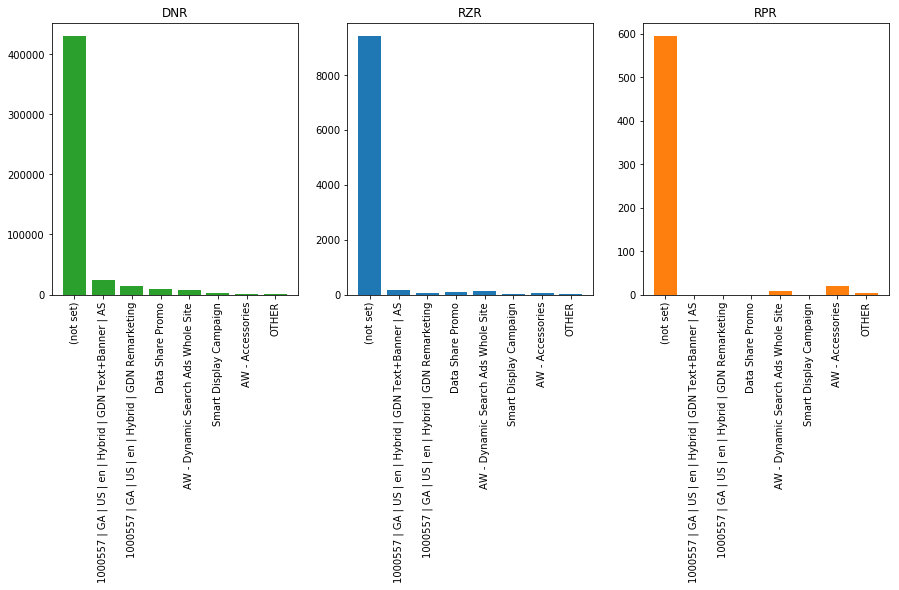

In [60]:
feature = 'trafficSource.campaign'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>1000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.keyword

In [61]:
train_slice['trafficSource.keyword'].value_counts(dropna=False)

NaN                                                                                  225209
(not provided)                                                                       219625
(User vertical targeting)                                                             22949
(automatic matching)                                                                  16928
6qEhsCssdK0z36ri                                                                       5795
(Remarketing/Content targeting)                                                        2526
1hZbAqLCbjwfgOH7                                                                       1574
1X4Me6ZKNV0zg-jV                                                                        855
google merchandise store                                                                535
Google Merchandise                                                                      356
google store                                                                    

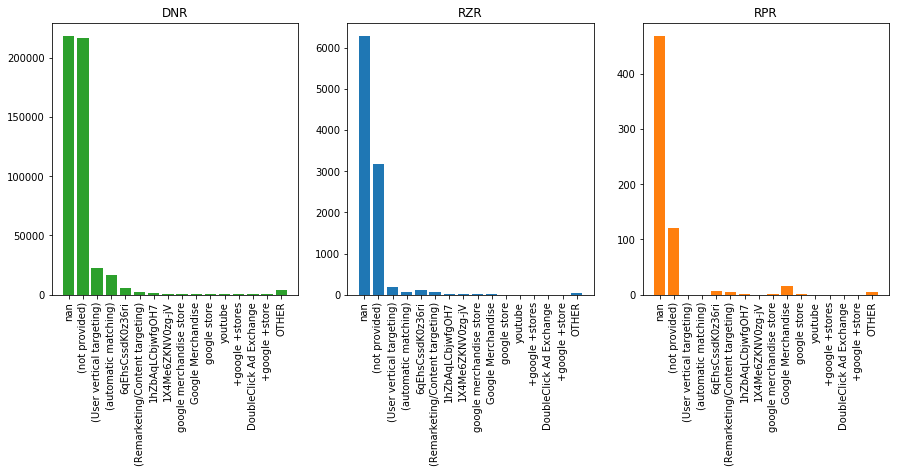

In [62]:
feature = 'trafficSource.keyword'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>100].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.referralPath

In [63]:
train_slice['trafficSource.referralPath'].value_counts(dropna=False)

NaN                                                                                                                                                                   374750
/                                                                                                                                                                      40419
/analytics/web/                                                                                                                                                        11269
/yt/about/                                                                                                                                                              5445
/offer/2145                                                                                                                                                             3970
/yt/about/copyright/                                                                                                                   

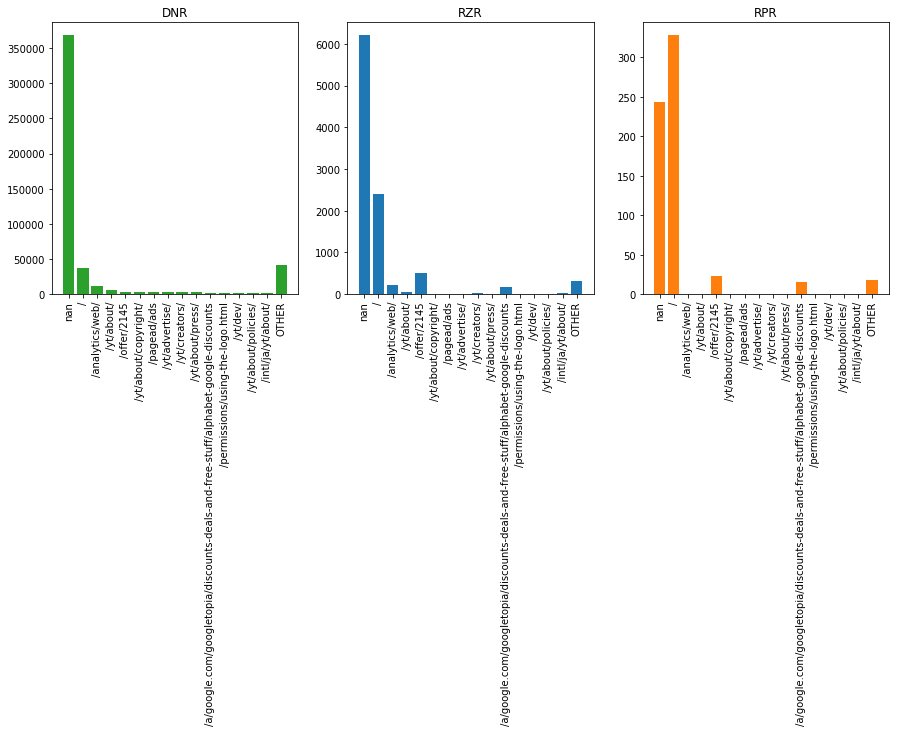

In [64]:
feature = 'trafficSource.referralPath'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>1000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.source

In [65]:
train_slice['trafficSource.source'].value_counts(dropna=False)

google                         277867
(direct)                       124475
youtube.com                     54821
analytics.google.com            11352
Partners                         8800
googleads.g.doubleclick.net      3328
sites.google.com                 2985
m.facebook.com                   2839
google.com                       2237
reddit.com                       1349
baidu                            1065
bing                              987
qiita.com                         895
facebook.com                      893
quora.com                         795
yahoo                             671
dfa                               576
mail.google.com                   532
l.facebook.com                    516
groups.google.com                 468
blog.golang.org                   382
t.co                              372
productforums.google.com          211
support.google.com                206
plus.url.google.com               201
google.co.jp                      196
docs.google.

In [66]:
train_slice_RPR['trafficSource.source'].value_counts(dropna=False)

(direct)               430
google                 163
sites.google.com        16
groups.google.com       12
optimize.google.com      2
youtube.com              2
bing                     1
reddit.com               1
Name: trafficSource.source, dtype: int64

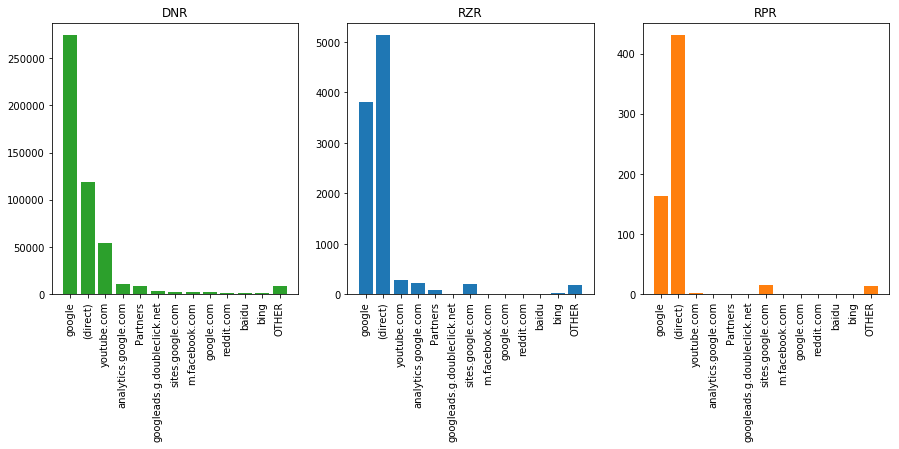

In [67]:
feature = 'trafficSource.source'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>900].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### visitStartTime_day

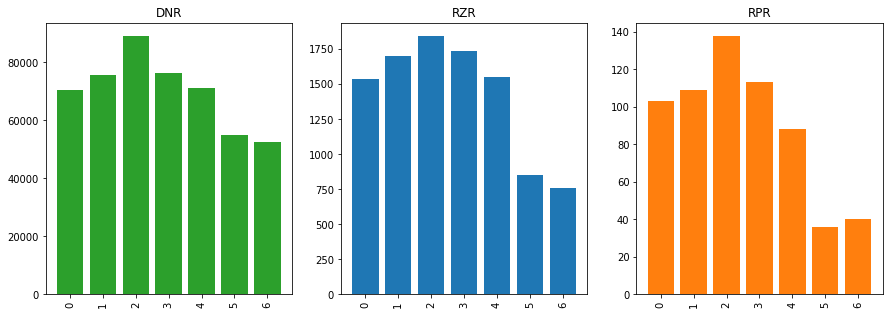

In [68]:
feature = 'visitStartTime_day'

unique_vals = train_slice[feature].unique()
unique_vals = np.sort(unique_vals)
n_vals = len(unique_vals)

val_counts_DNR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature].isnull()])
    else:
        val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature]==unique_vals[i]])

val_counts_RZR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature].isnull()])
    else:
        val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature]==unique_vals[i]])

val_counts_RPR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature].isnull()])
    else:
        val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature]==unique_vals[i]])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax[0].bar(np.arange(n_vals),val_counts_DNR,color='C2')
ax[0].set_xticks(np.arange(n_vals))
ax[0].set_xticklabels(unique_vals, rotation=90)
ax[0].set_title('DNR')

ax[1].bar(np.arange(n_vals),val_counts_RZR,color='C0')
ax[1].set_xticks(np.arange(n_vals))
ax[1].set_xticklabels(unique_vals, rotation=90)
ax[1].set_title('RZR')

ax[2].bar(np.arange(n_vals),val_counts_RPR,color='C1')
ax[2].set_xticks(np.arange(n_vals))
ax[2].set_xticklabels(unique_vals, rotation=90)
ax[2].set_title('RPR')

plt.show(fig)

### Continuous features

#### visitStartTime_hour

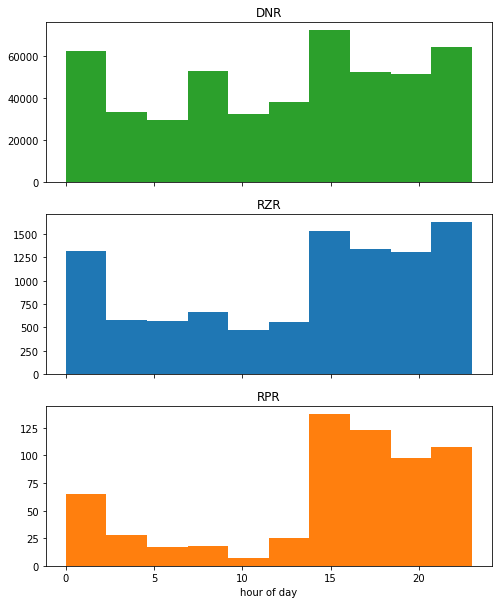

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(train_slice_DNR['visitStartTime_hour'], color='C2')
ax[0].set_title('DNR')

ax[1].hist(train_slice_RZR['visitStartTime_hour'], color='C0')
ax[1].set_title('RZR')

ax[2].hist(train_slice_RPR['visitStartTime_hour'], color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('hour of day')

plt.show(fig)

R^2    = 0.04002604435796357
p-val. = 4.400147876398425e-07


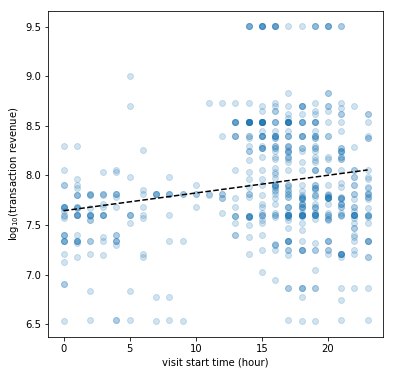

In [70]:
fig, ax = plt.subplots(figsize=(6,6))

x = train_slice_RPR['visitStartTime_hour']
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('visit start time (hour)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.hits

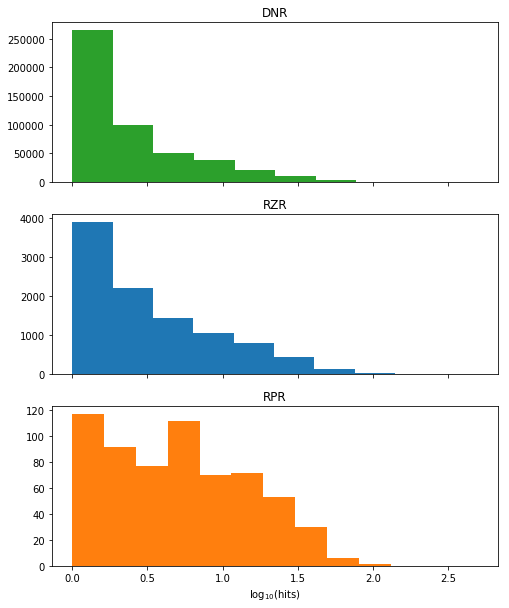

In [71]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_slice_DNR['totals.hits']), color='C2')
ax[0].set_title('DNR')

ax[1].hist(np.log10(train_slice_RZR['totals.hits']), color='C0')
ax[1].set_title('RZR')

ax[2].hist(np.log10(train_slice_RPR['totals.hits']), color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('log$_{10}$(hits)')

plt.show(fig)

R^2    = 0.040753631254012435
p-val. = 3.4428339517039814e-07


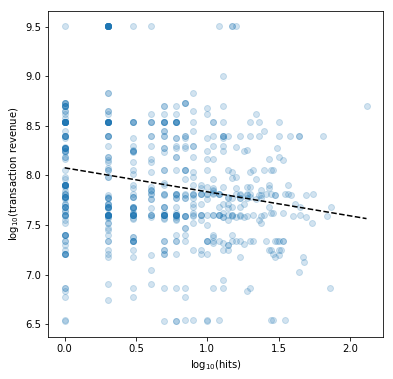

In [72]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_slice_RPR['totals.hits'])
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(hits)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.pageviews

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


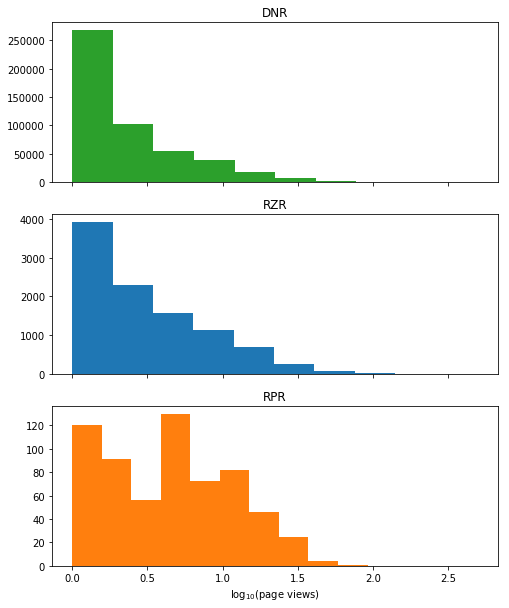

In [73]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_slice_DNR['totals.pageviews']), color='C2')
ax[0].set_title('DNR')

ax[1].hist(np.log10(train_slice_RZR['totals.pageviews']), color='C0')
ax[1].set_title('RZR')

ax[2].hist(np.log10(train_slice_RPR['totals.pageviews']), color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('log$_{10}$(page views)')

plt.show(fig)

R^2    = 0.038406630180009727
p-val. = 7.595749927755698e-07


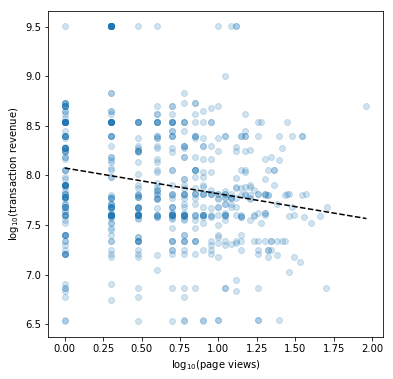

In [74]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_slice_RPR['totals.pageviews'])
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(page views)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.sessionQualityDim

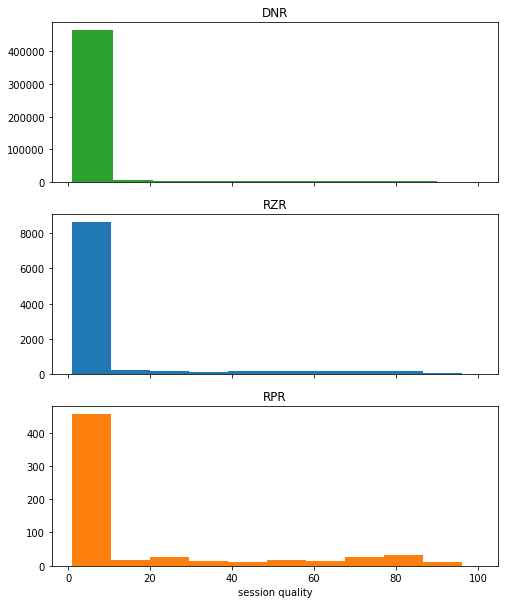

In [75]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(train_slice_DNR['totals.sessionQualityDim'], color='C2')
ax[0].set_title('DNR')

ax[1].hist(train_slice_RZR['totals.sessionQualityDim'], color='C0')
ax[1].set_title('RZR')

ax[2].hist(train_slice_RPR['totals.sessionQualityDim'], color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('session quality')

plt.show(fig)

R^2    = 0.010030225519842905
p-val. = 0.012104433656506186


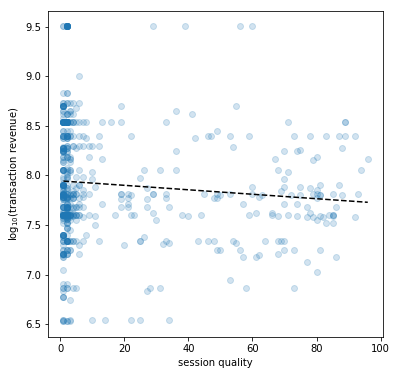

In [76]:
fig, ax = plt.subplots(figsize=(6,6))

x = train_slice_RPR['totals.sessionQualityDim']
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('session quality')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.timeOnSite

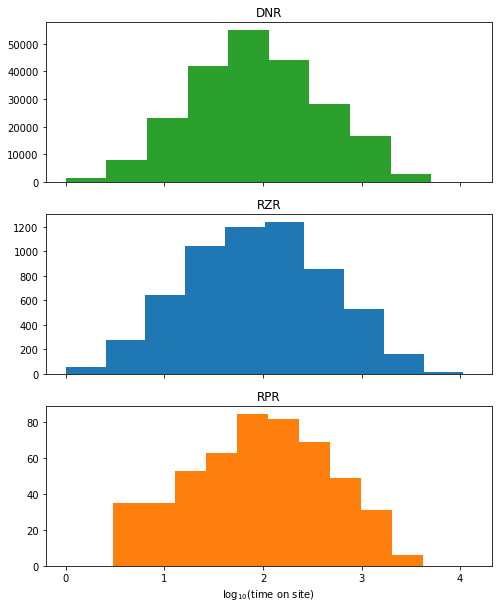

In [77]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_slice_DNR['totals.timeOnSite']), color='C2')
ax[0].set_title('DNR')

ax[1].hist(np.log10(train_slice_RZR['totals.timeOnSite']), color='C0')
ax[1].set_title('RZR')

ax[2].hist(np.log10(train_slice_RPR['totals.timeOnSite']), color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('log$_{10}$(time on site)')

plt.show(fig)

R^2    = nan
p-val. = nan


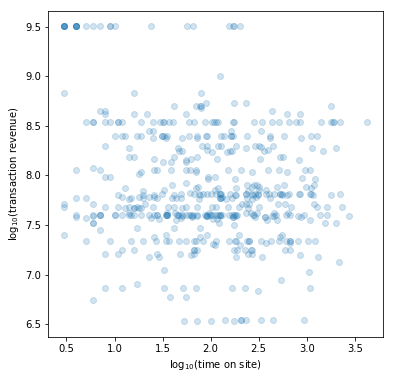

In [78]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_slice_RPR['totals.timeOnSite'])
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(time on site)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

## Initial Features

* channelGrouping
* device.browser
* device.deviceCategory
* device.operatingSystem
* geoNetwork.subContinent
* trafficSource.medium
* trafficSource.source
* visitStartTime_day
* visitStartTime_hour
* totals.hits
* totals.pageviews
* totals.sessionQualityDim

In [79]:
train_subset = pd.DataFrame()

channelGrouping

In [80]:
train_subset['channelGrouping'] = train_slice['channelGrouping'].copy()

device.browser

In [81]:
feature = 'device.browser'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>200].index.to_list()

train_subset[feature] = train_slice[feature].copy()
train_subset.loc[~train_subset[feature].isin(unique_vals), feature] = 'OTHER'

device.deviceCategory

In [82]:
train_subset['device.deviceCategory'] = train_slice['device.deviceCategory'].copy()

device.operatingSystem

In [83]:
feature = 'device.operatingSystem'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>300].index.to_list()

train_subset[feature] = train_slice[feature].copy()
train_subset.loc[~train_subset[feature].isin(unique_vals), feature] = 'OTHER'

geoNetwork.subContinent

In [84]:
train_subset['geoNetwork.subContinent'] = train_slice['geoNetwork.subContinent'].copy()

trafficSource.medium

In [85]:
train_subset['trafficSource.medium'] = train_slice['trafficSource.medium'].copy()

trafficSource.source

In [86]:
feature = 'trafficSource.source'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>900].index.to_list()

train_subset[feature] = train_slice[feature].copy()
train_subset.loc[~train_subset[feature].isin(unique_vals), feature] = 'OTHER'

visitStartTime_day

In [87]:
train_subset['visitStartTime_day'] = train_slice['visitStartTime_day'].copy()

visitStartTime_hour

In [88]:
train_subset['visitStartTime_hour'] = train_slice['visitStartTime_hour'].copy()

totals.hits

In [89]:
train_subset['totals.hits'] = train_slice['totals.hits'].copy()

totals.pageviews

In [90]:
train_subset['totals.pageviews'] = train_slice['totals.pageviews'].copy()

totals.sessionQualityDim

In [91]:
train_subset['totals.sessionQualityDim'] = train_slice['totals.sessionQualityDim'].copy()